In [3]:
from enum import Enum

class Operator(Enum):
    ADD = '+'
    MUL = '*'
    POW = '^'
    NEG = '-'
    LOG = 'ln'

    def __str__(self):
        return self.value

In [4]:
from graphviz import Digraph
from IPython.display import display

def visualize(tensor, graph='compute graph'):
    dot = Digraph(comment=graph)
    added_edges = set()

    def add_node(x):
        fillcolor = 'white' if x.requires_grad else 'lightcoral'
        if graph == 'compute graph':
            dot.node(str(id(x)), f"{x.data:.3f}", style='filled', fillcolor=fillcolor)
        else:
            dot.node(str(id(x)), f"{x.grad:.3f}", style='filled', fillcolor=fillcolor)
    # add_node = lambda x: 
    add_op_node = lambda x: dot.node(str(id(x)), str(x.type))

    def add_edge(start,end):
        x = str(id(start))
        y = str(id(end))
        edge = (x,y)
        if edge not in added_edges:
            dot.edges([edge])
            added_edges.add(edge)


    def make_graph(t: Tensor):
        add_node(t)
        if t.op:
            add_op_node(t.op)
            if graph == 'compute graph':
                add_edge(t.op, t)
            else: 
                add_edge(t, t.op)

            if t.op.left:
                make_graph(t.op.left)
                if graph == 'compute graph':
                    add_edge(t.op.left, t.op)
                else: 
                    add_edge(t.op, t.op.left)

            if t.op.right:
                make_graph(t.op.right)
                if graph =='compute graph':
                    add_edge(t.op.right, t.op)
                else:
                    add_edge(t.op, t.op.right)
    make_graph(tensor)
    display(dot)

In [5]:
from dataclasses import dataclass
class Op:
    def __init__(self, type: str, left, right=None):
        self.type = type
        self.left = left
        self.right = right

In [112]:
import numpy as np
import math
class Tensor:

    def __init__(self, data, op: Op |None = None, requires_grad: bool = True):
        if isinstance(data, np.ndarray):
            self.data = data if data.dtype == np.float32 else data.astype(np.float32)
        else:
            self.data = np.array(data, dtype=np.float32)
        self.op = op
        self.requires_grad = requires_grad
        self._grad = None
    @property
    def grad(self):
        if self._grad is None and self.requires_grad:
            self._grad = np.zeros_like(self.data)
        return self._grad

    @grad.setter
    def grad(self, value):
        if self._grad is None:
            return
        self._grad = value

    @staticmethod
    def ensure_tensor(value, requires_grad=False):
        return value if isinstance(value, Tensor) else Tensor(value, requires_grad=requires_grad)

    def validate_arg(fn):
        def wrapper(self, other):
            other = Tensor.ensure_tensor(other, requires_grad=False)
            return fn(self, other)
        return wrapper

    @validate_arg
    def __add__(self, other):
        n = self.data + other.data
        op = Op(Operator.ADD, self, other)
        return Tensor(n, op)

    def __radd__(self, other):
        return self + other

    @validate_arg
    def __mul__(self, other):
        n = self.data * other.data
        op = Op(Operator.MUL, self, other)
        return Tensor(n, op)
    
    def __rmul__(self, other):
        return self * other
    
    @validate_arg
    def __pow__(self, power):
        n = np.power(self.data, power.data)
        op = Op(Operator.POW, self, power)
        return Tensor(n, op)
    
    @validate_arg
    def __rpow__(self, base):
        return base ** self
    
    @validate_arg
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return -self + other
    
    @validate_arg
    def __truediv__(self, other):
        return self * other ** -1 
    
    def __rtruediv__(self, other):
        return other * self ** -1

    def __neg__(self):
        data = -self.data
        op = Op(Operator.NEG, self)
        return Tensor(data, op)
    
    def log(self):
        data = np.log(self.data)
        op = Op(Operator.LOG, self)
        return Tensor(data, op)


    def backward(self):
        self.grad += 1.0
        self._backward()
    def update_grad(self, value):
        if self.grad is None:
            return
        self.grad += value

    def _backward(self):
        op = self.op
        if not op:
            return
        match op.type:
            case Operator.ADD:
                left_grad = right_grad = self.grad
            case Operator.MUL:
                left_grad = self.grad * op.right.data 
                right_grad = self.grad * op.left.data

            case Operator.POW:
                n = op.right.data
                left_grad = self.grad * n * op.left.data ** (n-1)

                base = op.left.data
                right_grad = self.grad * self.data * np.log(base)

            case Operator.NEG:
                assert op.right is None, "Unary Operation can't have two operands"
                left_grad = -self.grad
            case Operator.LOG:
                assert op.right is None, "Unary Operation can't have two operands"
                left_grad = self.grad * (op.left.data ** -1)
            
        op.left.update_grad(left_grad) 
        op.right.update_grad(right_grad) 

        # if op.left:
        op.left._backward() 
        if op.right:
            op.right._backward()
    def item(self):
        return self.data.item()
    def __repr__(self):
        return f"Tensor(data={self.data},grad={self.grad}, requires_grad={self.requires_grad}, op={self.op})"

@dataclass
class Optimizer:
    params: list[Tensor]
    lr: float= 0.01

    def step(self):
        for param in self.params:
            if param.requires_grad:
                param.data = param.data - self.lr * param.grad

    def zero_grad(self):
        for t in self.params:
            t.grad = 0.0

In [122]:
import numpy as np

# Test addition
t1 = Tensor([1, 2, 3])
t2 = Tensor([4, 5, 6])
add_result = t1 + t2
# print("Addition:", add_result)
assert (add_result.data == [5, 7, 9]).all(), "Addition failed"

# Test multiplication
mul_result = t1 * t2
# print("Multiplication:", mul_result)
assert (mul_result.data == [4, 10, 18]).all(), "Multiplication failed"

# Test power
pow_result = t1 ** Tensor([2, 2, 2])
# print("Power:", pow_result)
assert (pow_result.data == [1, 4, 9]).all(), "Power failed"

# Test negation
neg_result = -t1
# print("Negation:", neg_result)
assert (neg_result.data == [-1, -2, -3]).all(), "Negation failed"

# Test subtraction
sub_result = t2 - t1
# print("Subtraction:", sub_result)
assert (sub_result.data == [3, 3, 3]).all(), "Subtraction failed"

# Test division
div_result = t2 / t1
# print("Division:", div_result)
assert (div_result.data == [4, 2.5, 2]).all(), "Division failed"

# Test logarithm
log_result = t2.log()
# print("Logarithm:", log_result)
assert np.allclose(log_result.data, np.log([4, 5, 6])), "Logarithm failed"

# Test backward for addition
add_result.backward()
# print("t1.grad after add backward:", t1.grad)
# print("t2.grad after add backward:", t2.grad)
assert (t1.grad == [1, 1, 1]).all(), "Addition backward failed for t1"
assert (t2.grad == [1, 1, 1]).all(), "Addition backward failed for t2"

# Test backward for multiplication
t1 = Tensor([1, 2, 3])
t2 = Tensor([4, 5, 6])
mul_result = t1 * t2
mul_result.backward()
# print("t1.grad after mul backward:", t1.grad)
# print("t2.grad after mul backward:", t2.grad)
assert (t1.grad == [4, 5, 6]).all(), "Multiplication backward failed for t1"
assert (t2.grad == [1, 2, 3]).all(), "Multiplication backward failed for t2"

print("All tests passed!")

All tests passed!


In [570]:
class Module:
    def params(self):
        return self._collect_params(self.__dict__)

    def _collect_params(self, obj):
        params = []

        if isinstance(obj, Tensor):
            params.append(obj)

        elif isinstance(obj, Module):
            params.extend(obj.params())

        elif isinstance(obj, dict):
            for v in obj.values():
                params.extend(self._collect_params(v))

        elif isinstance(obj, (list, tuple)):
            for item in obj:
                params.extend(self._collect_params(item))

        return params
    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

In [571]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

from random import uniform
class Linear(Module):
    def __init__(self, in_features:int , out_features: int, bias=True):
        self.input = in_features
        self.output = out_features
        self.bias_flag = bias

        self.weights = [Tensor(self.init_weight()) for _ in range(self.input * self.output)]
        if bias:
            self.bias = [Tensor(self.init_weight()) for _ in range(self.output)]
        else: 
            self.bias = [0]*len(self.output) # on the assumption that raw int value converted to Tensor are always with requires grad= False
    def init_weight(self):
        return uniform(-0.5, 0.5)
    def forward(self, x: list):
        assert len(x[0]) == self.input, f"Got {len(x)} features, expected {self.input}"

        output = []
        dot_prod = lambda x, w, b: sum([xi * wi for xi, wi in zip(x,w)], b)

        # the loop un-batches the input -- gets single input point at a time
        for inp in x: 
            weight = chunks(self.weights, self.input) 
            out = [dot_prod(inp, w, b) for w, b in zip(weight, self.bias)]
            output.append(out)
        return output


In [572]:
sigmoid = lambda x: 1/(1+math.e**-x)

In [573]:
class BCELogitsLoss:
    def __init__(self):
        self.sigmoid = lambda x: [sigmoid(v) for v in x]
        self.threshold = 1e-6
    def __call__(self, logits, labels):
        eps = self.threshold
        logits = [x for sample in logits for x in sample]
        prob = self.sigmoid(logits)
        loss = [
            -(y * (eps + p).log() + (1-y)*(1-p + eps).log())
            for y, p in zip(labels, prob)
        ]
        
        return sum(loss)/len(loss)

In [574]:
class XOR(Module):
    def __init__(self):
        self.hidden_layer = Linear(2,2)
        self.output_layer = Linear(2,1)
        self.activation = lambda x: [[sigmoid(x) for x in sample] for sample in x]

    def forward(self, x):
        # x [B, (F)]
        x = self.hidden_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x
        # return self.activation(x) #if prob = 0 then log(0) will go mad; handle this in loss function

In [ ]:
def train(model, x, y, optimizer:Optimizer, loss, epoch):
    loss_history = []
    for i in range(epoch):
        optimizer.zero_grad()
        y_pred = model(x)
        output: Tensor= loss(y_pred, y)
        output.backward()
        optimizer.step()

        loss_history.append(output.item())

        if i % 10 == 0:
            print(f"Epoch {i}: Loss: {output.item()}")
    plot(loss_history, epoch) 
    return model

def plot(loss_history, epoch):
    import matplotlib.pyplot as plt
    plt.plot(range(epoch), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.show()

In [576]:
x = [(0,0), (0,1), (1,0), (1,1)]
y = [0, 1, 1, 0]

In [577]:
model = XOR()
y_pred = model(x)
optimizer = Optimizer(model.params())
loss = BCELogitsLoss()
epoch = 1000000

In [578]:
model.params()

[Tensor(data=0.09592145808828201, op=None, grad=0.0, requires_grad=True),
 Tensor(data=-0.23893297378029454, op=None, grad=0.0, requires_grad=True),
 Tensor(data=0.34117571097751576, op=None, grad=0.0, requires_grad=True),
 Tensor(data=-0.3009979701557969, op=None, grad=0.0, requires_grad=True),
 Tensor(data=-0.34036536025400566, op=None, grad=0.0, requires_grad=True),
 Tensor(data=0.1877682672178318, op=None, grad=0.0, requires_grad=True),
 Tensor(data=0.0627507788880074, op=None, grad=0.0, requires_grad=True),
 Tensor(data=0.25120943084164926, op=None, grad=0.0, requires_grad=True),
 Tensor(data=-0.009588850520122483, op=None, grad=0.0, requires_grad=True)]

Epoch 0: Loss: 0.6962058529051827
Epoch 10: Loss: 0.7107405514512333
Epoch 20: Loss: 0.7326763668217987
Epoch 30: Loss: 0.7584222098026319
Epoch 40: Loss: 0.7857075816351993
Epoch 50: Loss: 0.8131378779372025
Epoch 60: Loss: 0.8398827386808048
Epoch 70: Loss: 0.8654694963984952
Epoch 80: Loss: 0.8896499771036606
Epoch 90: Loss: 0.9123156544022577
Epoch 100: Loss: 0.93344384215194
Epoch 110: Loss: 0.9530635969268868
Epoch 120: Loss: 0.971234106374206
Epoch 130: Loss: 0.9880310028349779
Epoch 140: Loss: 1.003537727403148
Epoch 150: Loss: 1.0178401267144992
Epoch 160: Loss: 1.031023126928674
Epoch 170: Loss: 1.0431687455999827
Epoch 180: Loss: 1.0543549653425965
Epoch 190: Loss: 1.0646551608437704
Epoch 200: Loss: 1.0741378783785474
Epoch 210: Loss: 1.082866836561702
Epoch 220: Loss: 1.0909010623897029
Epoch 230: Loss: 1.098295106326896
Epoch 240: Loss: 1.1050992997616012
Epoch 250: Loss: 1.1113600311081338
Epoch 260: Loss: 1.1171200254229894
Epoch 270: Loss: 1.1224186181094602
Epoch 280:

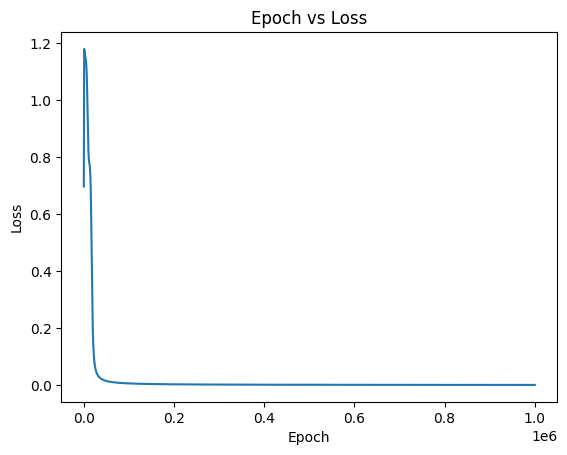

[Tensor(data=8.638881131156573, op=None, grad=-4.3143358259775575e-05, requires_grad=True),
 Tensor(data=8.59815679574171, op=None, grad=-4.3122998766313596e-05, requires_grad=True),
 Tensor(data=6.9161657923502275, op=None, grad=-4.4476558458219365e-05, requires_grad=True),
 Tensor(data=6.961462092724807, op=None, grad=-4.459864836131179e-05, requires_grad=True),
 Tensor(data=-3.630111945647424, op=None, grad=2.3793862211873717e-05, requires_grad=True),
 Tensor(data=-10.857604200564229, op=None, grad=6.68076143842459e-05, requires_grad=True),
 Tensor(data=17.11570582353405, op=None, grad=-0.00019151165319909204, requires_grad=True),
 Tensor(data=-17.677614021074874, op=None, grad=0.00019157494178955722, requires_grad=True),
 Tensor(data=-7.349759808153165, op=None, grad=9.44045506134994e-05, requires_grad=True)]

In [579]:
model = train(model,x,y, optimizer, loss, epoch)
model.params()

In [583]:
y_pred = model(x)

In [585]:
preds = [[round(sigmoid(tensor.data)) for tensor in sample] for sample in y_pred]
print("Predictions:", preds)
print("Ground Truth:", y)

Predictions: [[0], [1], [1], [0]]
Ground Truth: [0, 1, 1, 0]


In [587]:
model.params()

[Tensor(data=8.638881131156573, op=None, grad=-4.3143358259775575e-05, requires_grad=True),
 Tensor(data=8.59815679574171, op=None, grad=-4.3122998766313596e-05, requires_grad=True),
 Tensor(data=6.9161657923502275, op=None, grad=-4.4476558458219365e-05, requires_grad=True),
 Tensor(data=6.961462092724807, op=None, grad=-4.459864836131179e-05, requires_grad=True),
 Tensor(data=-3.630111945647424, op=None, grad=2.3793862211873717e-05, requires_grad=True),
 Tensor(data=-10.857604200564229, op=None, grad=6.68076143842459e-05, requires_grad=True),
 Tensor(data=17.11570582353405, op=None, grad=-0.00019151165319909204, requires_grad=True),
 Tensor(data=-17.677614021074874, op=None, grad=0.00019157494178955722, requires_grad=True),
 Tensor(data=-7.349759808153165, op=None, grad=9.44045506134994e-05, requires_grad=True)]

In [589]:
xor = XOR()
xl = BCELogitsLoss()

In [590]:
y_p = xor(x)

In [592]:
out = xl(y_p, y)

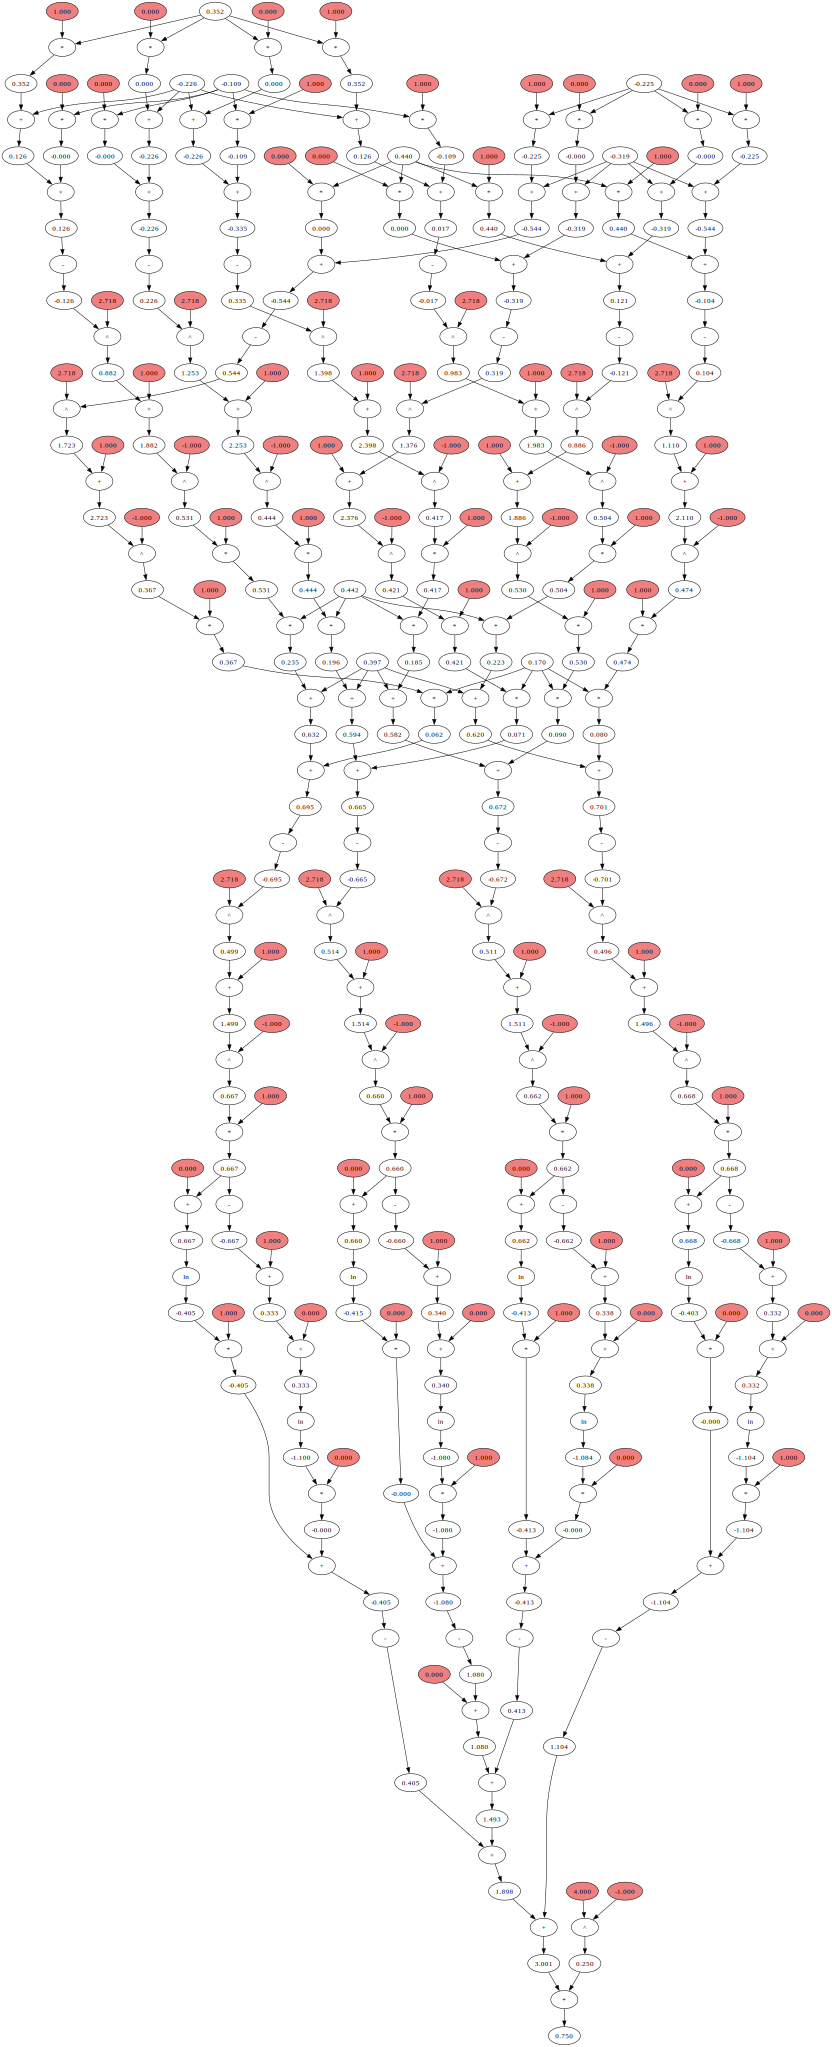

In [593]:
visualize(out)